<a href="https://colab.research.google.com/github/Ape108/Quantum_Portfolio_Optimization/blob/main/qubo_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# QUBO - Quadratic Unconstrained Binary Optimization


*Example Values*

In [3]:
import numpy as np

size = 5
features = np.array([1,0,0,1,1]) # x^T vector
weights = np.triu(np.array([ # Upper Triangular Matrix Q
    [ 0.5, -1.0,  0.2, -0.8,  1.5],
    [-1.0,  0.3, -0.5,  1.0, -0.2],
    [ 0.2, -0.5, -0.1,  0.6, -1.1],
    [-0.8,  1.0,  0.6,  0.9,  0.4],
    [ 1.5, -0.2, -1.1,  0.4, -0.7]
    ]))


### Summation Form (General)<br>
## $E(\mathbf{x}) = \sum_{i=1}^{n} Q_{ii}x_i + \sum_{i=1}^{n-1}\sum_{j=i+1}^{n} Q_{ij}x_i x_j$


In [15]:
def get_cost_summation_form(weights, features, size):
  # Summation Form
  linear_sum = 0
  for i in range(size):
    Q_ii = weights[i][i]
    x_i = features[i]
    linear_sum += (Q_ii * x_i)

  quadratic_sum = 0
  for j in range(size):
    for i in range(j):
      Q_ij = weights[i][j]
      x_i = features[i]
      x_j = features[j]
      quadratic_sum += (Q_ij * x_i * x_j)

  energy_cost = linear_sum + quadratic_sum

  print("linear_sum + quadratic_sum = energy_cost")
  print(f"{linear_sum} + {quadratic_sum} = {energy_cost:.2f}")

get_cost_summation_form(weights, features, size)

linear_sum + quadratic_sum = energy_cost
0.7 + 1.1 = 1.80


### Matrix Form (General)<br>
## $E(\mathbf{x}) = \mathbf{x}^\top Q \mathbf{x}$


In [22]:
def get_cost_matrix_form(weights, features):
  x_T = features
  Q = weights
  x = features.T

  energy_cost = x_T @ Q @ x

  print("x_T @ Q @ x = energy_cost")
  print(f"{x_T} @ \n{Q} @ \n{x}^T \n= {energy_cost:.2f}")

get_cost_matrix_form(weights, features)


x_T @ Q @ x = energy_cost
[1 0 0 1 1] @ 
[[ 0.5 -1.   0.2 -0.8  1.5]
 [ 0.   0.3 -0.5  1.  -0.2]
 [ 0.   0.  -0.1  0.6 -1.1]
 [ 0.   0.   0.   0.9  0.4]
 [ 0.   0.   0.   0.  -0.7]] @ 
[1 0 0 1 1]^T 
= 1.80


# Portfolio Optimization Application

In [32]:
import pandas as pd
import yfinance as yf

xlk_top_ten = ['NVDA', 'MSFT', 'AAPL', 'AVGO', 'ORCL', 'PLTR', 'AMD', 'CSCO', 'CRM', 'IBM']

# Value of the stock at the end of the day
adj_close_df = yf.download(xlk_top_ten, period='5y')['Close']

# (Current day's price - Previous day's price) / Previous day's price
daily_returns = adj_close_df.pct_change()

# Drop NaN value for first day (no previous day)
daily_returns = daily_returns.dropna()

print("--- Daily Returns ---")
print(daily_returns.head())


# There are about 252 trading days in a year
# Calculate annualized expected returns (mu)
mu = daily_returns.mean() * 252

# Calculate annualized covariance matrix (Sigma)
Sigma = daily_returns.cov() * 252


/tmp/ipython-input-835155751.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  adj_close_df = yf.download(xlk_top_ten, period='5y')['Close']
[*********************100%***********************]  10 of 10 completed

--- Daily Returns ---
Ticker          AAPL       AMD      AVGO       CRM      CSCO       IBM  \
Date                                                                     
2020-10-01  0.008462  0.035004  0.011748  0.008475 -0.005893 -0.004767   
2020-10-02 -0.032280 -0.036059 -0.031931 -0.022095 -0.013660 -0.004294   
2020-10-05  0.030791  0.053178  0.025979  0.014848  0.007839  0.011943   
2020-10-06 -0.028669 -0.019385 -0.005791 -0.005526  0.000000 -0.000328   
2020-10-07  0.016967  0.026160  0.007583  0.039338  0.021520  0.017217   

Ticker          MSFT      NVDA      ORCL      PLTR  
Date                                                
2020-10-01  0.010127  0.006208 -0.000335 -0.004211  
2020-10-02 -0.029511 -0.040564 -0.014243 -0.027484  
2020-10-05  0.020321  0.044422  0.012409 -0.018478  
2020-10-06 -0.021247  0.006890 -0.000839  0.096346  
2020-10-07  0.019037  0.016562  0.022271  0.010101  


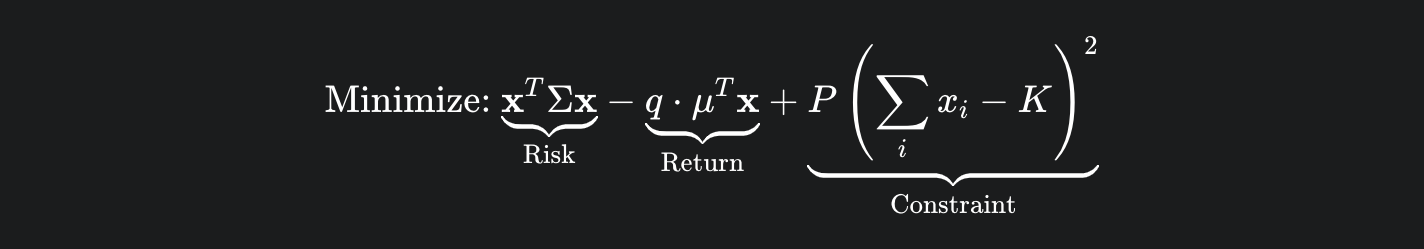

In [57]:
from collections import defaultdict

# --- Parameters to set by the user ---
# Number of assets to select in the portfolio
K = 3
# Risk aversion parameter (higher q = more focus on returns)
q = 0.5
# Penalty for violating the constraint (must be large enough)
P = 1.0

# Get the list of tickers
tickers = xlk_top_ten
num_assets = len(tickers)

# --- Build the Q matrix ---
Q = defaultdict(float)

# 1. Add the risk term (covariance)
for i in range(num_assets):
  for j in range(num_assets):
    Q[(i, j)] += Sigma.iloc[i, j]

# 2. Add the return term (negated for minimization)
for i in range(num_assets):
  Q[(i,i)] -= q * mu.iloc[i]


# 3. Add the constraint penalty
# The penalty (sum(xi) - K)^2 expands to:
# sum(xi^2) - 2K*sum(xi) + K^2
# Since xi is binary, xi^2 = xi. So it becomes:
# (1 - 2K)*sum(xi) + 2*sum_{i<j}(xi*xj) + K^2
# (We can ignore the constant K^2)
for i in range(num_assets):
  Q[(i, i)] += P * (1 - 2 * K)
  for j in range(i + 1, num_assets):
    Q[(i, j)] += P * 2

print("--- Sample of Q matrix elements ---")
for i, j in list(Q.keys())[:5]:
    print(f"Q[({i},{j})]: {Q[(i,j)]:.4f}")


--- Sample of Q matrix elements ---
Q[(0,0)]: -5.0123
Q[(0,1)]: 2.0762
Q[(0,2)]: 2.0569
Q[(0,3)]: 2.0485
Q[(0,4)]: 2.0303


Now that we have converted the data into a QUBO problem, we need to evaluate it. That would be where techniques like QAOA and Quantum Annealing come in. Below is an algorithm to solve it by brute force, but this is only possible because we have 10 assets, and $C(10, 5) = 252$.

In [58]:
# Brute Force Evaluation (Generated by Gemini)

from itertools import combinations

# --- Brute-Force Search for the Optimal Portfolio ---

# You can use the K and q parameters you defined previously
num_assets_to_select = K
risk_aversion = q

# Initialize variables to store the best result
best_combo = None
best_score = float('inf') # Start with a very high score to minimize

# Get the list of asset tickers
tickers = mu.index # Assumes tickers are the index of your mu Series

print(f"Searching all {len(list(combinations(tickers, num_assets_to_select)))} combinations of {num_assets_to_select} assets...")

# Generate and loop through every possible combination of K tickers
for combo in combinations(tickers, num_assets_to_select):

    # Convert combo tuple to a list for slicing
    combo_list = list(combo)

    # Slice the mu and Sigma matrices for the current combination
    combo_mu = mu[combo_list]
    combo_sigma = Sigma.loc[combo_list, combo_list]

    # Calculate the score for this combination (objective: minimize Risk - q*Return)
    # The portfolio variance is the sum of all elements in the sub-covariance matrix
    portfolio_variance = combo_sigma.sum().sum()
    # The portfolio return is the sum of the returns of the selected assets
    portfolio_return = combo_mu.sum()

    score = portfolio_variance - risk_aversion * portfolio_return

    # If this combination's score is the best we've seen, save it
    if score < best_score:
        best_score = score
        best_combo = combo

print("\n--- Optimal Portfolio Found via Brute-Force ---")
print(f"Selected Assets: {best_combo}")
print(f"Objective Score: {best_score:.4f}")

Searching all 120 combinations of 3 assets...

--- Optimal Portfolio Found via Brute-Force ---
Selected Assets: ('AVGO', 'CSCO', 'IBM')
Objective Score: -0.0269
